### Imports

In [1]:
# Standard Library
import math, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# PyTorch - Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Qiskit - Quantum Computing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.tools.monitor import job_monitor
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.utils import QuantumInstance

### Neural Networks

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        
        self.max_action = max_action
        
    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = torch.sigmoid(self.l3(a)) * self.max_action
        return a
        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)
        
        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

### Memory

In [3]:
class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

### Agent

In [4]:
class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        
        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()
            
            # Delayed policy updates:
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()
                
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                    
                
    def save(self, directory, name):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, name))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target.pth' % (directory, name))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1.pth' % (directory, name))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target.pth' % (directory, name))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2.pth' % (directory, name))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target.pth' % (directory, name))
        
    def load(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        
    def load_actor(self, directory, name):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
    def load_critic(self, directory, name):
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1.pth' % (directory, name), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target.pth' % (directory, name), map_location=lambda storage, loc: storage))
        
        
      

### Environment

In [5]:
# See DOI: 10.1103/PhysRevX.6.031007
# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def get_probability_distribution_2(counts, NUM_SHOTS):
    #   output_distr = [v/NUM_SHOTS for v in counts.values()]
    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())
    # print(sorted_counts)
    output_distr = [v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr


def simulator(theta, shots):
    E = g0 + nuclear_repulsion

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2, 2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(1)
    circ.ry(np.pi / 2, 0)
    circ.rx(np.pi / 2, 1)
    circ.cx(0, 1)
    circ.rz(theta[0], 1)
    circ.cx(0, 1)
    circ.ry(theta[1], 0)
    circ.rx(theta[1], 1)
    circ.measure([0, 1], [0, 1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2, 2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(1)
    circ_2.ry(np.pi / 2, 0)
    circ_2.rx(np.pi / 2, 1)
    circ_2.cx(0, 1)
    circ_2.rz(theta[0], 1)
    circ_2.cx(0, 1)
    circ_2.ry(theta[1], 0)
    circ_2.rx(theta[1], 1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.measure([0, 1], [0, 1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2, 2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(1)
    circ_3.ry(np.pi / 2, 0)
    circ_3.rx(np.pi / 2, 1)
    circ_3.cx(0, 1)
    circ_3.rz(theta[0], 1)
    circ_3.cx(0, 1)
    circ_3.ry(theta[1], 0)
    circ_3.rx(theta[1], 1)
    circ_3.h(0)
    circ_3.h(1)
    circ_3.measure([0, 1], [0, 1])

    shots1, shots2, shots3 = shots

    # job = qpu_backend.run(circ, shots=shots1)
    job = execute(circ, Aer.get_backend('qasm_simulator'), shots=shots1)
    result = job.result()
    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # job = qpu_backend.run(circ_2, shots=shots2)
    job = execute(circ_2, Aer.get_backend('qasm_simulator'), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])

    # job = qpu_backend.run(circ_3, shots=shots3)
    job = execute(circ_3, Aer.get_backend('qasm_simulator'), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])

    return E


class Environ:
    def __init__(self):

        self.observation_space_dim = 1
        self.action_space_dim = 1
        self.std_threshold = 1e-3
        self.max_shots = 1000
        self.initialshots = 9

        self.high = 1
        self.low = 0
        
        self.iter_per_adamcall = 10
        
    def reset(self):

        self.theta = np.array([3.9, 2.0])

        # Initialize the ADAM variables
        self.t = 0
        self.m_t = 0
        self.v_t = 0
        
        self.totalshots = self.initialshots * self.iter_per_adamcall
        
        energies, gradents = self.adam(self.theta, shots=self.initialshots, iters=self.iter_per_adamcall)
        X = np.arange(self.iter_per_adamcall).reshape(-1,1)
        Y = np.array(energies).reshape(-1,1)

        reg = LinearRegression().fit(X, Y)
        R2 = reg.score(X, Y)
        self.min_value = np.mean(energies)

        Y_pred = reg.predict(X)
        mae = mean_absolute_error(Y_pred, Y)
        self.state = np.array([-math.log10(10e-5 if np.abs(reg.coef_[0,0])==0 else np.abs(reg.coef_[0,0])), 0.0])
        
        return self.state

    def step(self, action):
        shots = int(self.max_shots * action)

        if shots<=3:
            shots = 3

        energies, gradents = self.adam(self.theta, shots=shots, iters=self.iter_per_adamcall)
        
        X = np.arange(self.iter_per_adamcall).reshape(-1,1)
        Y = np.array(energies).reshape(-1,1)

        reg = LinearRegression().fit(X, Y)

        Y_pred = reg.predict(X)
        mae = mean_absolute_error(Y_pred, Y)
        R2 = reg.score(X, Y)

        if np.mean(energies)<self.min_value + self.min_value*0.05 or np.mean(energies)<self.min_value - self.min_value*0.05:
            state2 = 1.0
            if np.mean(energies)<self.min_value:
                self.min_value = np.mean(energies)
        else:
            state2 = 0.0
        self.state = np.array([-math.log10(10e-5 if np.abs(reg.coef_[0,0])<10e-5 else np.abs(reg.coef_[0,0])), state2])
        
        ## termination and rewards
        if self.state[0]>3.5 and state2==1:
            done = True
            reward = np.array([20])
        else:
            done = False
            reward = -np.array([shots/self.max_shots])
        print('energy mean: {:.4f}  state1: {:.4f} state2: {:.4f} mae: {:.4f} shots: {}  done: {} totalshots: {}'.format(np.mean(energies), self.state[0], self.state[1], R2, shots, done, self.totalshots))

        return self.state, reward[0], done, None

    def adam(self, theta, shots, iters):
        # initialize something
        base_lr = 0.05
        eps = 0.02
        nit = 0
        x_opt = np.copy(theta)

        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8

        energies = []
        gradents = []
        per_shots = shots // 3
        self.totalshots += per_shots*3*self.iter_per_adamcall
        
        while nit < iters:
            # Compute the function value and gradient
            fval, grad = self.func_and_gradient(x_opt, lambda x: simulator(x, shots=(per_shots, per_shots, per_shots)), eps)
            energies.append(fval)
            gradents.append(np.linalg.norm(grad))
            
            # gradient descent
            x_opt = x_opt - base_lr*grad

            nit += 1

        self.theta = x_opt

        return energies, gradents

    def func_and_gradient(self, x_opt, fun, eps):
        f = fun(x_opt)
        grad = np.zeros_like(x_opt)

        for i in range(x_opt.size):
            x_plus_h = x_opt.copy()
            x_plus_h[i] += eps
            f_plus_h = fun(x_plus_h)
            grad[i] = (f_plus_h - f) / eps

        return f, grad

### Train

In [6]:
# Save the log
class Logger(object):
    def __init__(self, file_name="Default.log", stream=sys.stdout):
        self.terminal = stream
        self.log = open(file_name, "w+")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        pass

In [7]:
# Configuration
NAME = 'example_1'
noise = 0.1
maxepisode = 20
maxstep = 10

In [8]:
REWARD = []

In [12]:
REWARD.append(1)

In [13]:
REWARD

[-5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [15]:
def train():
    ######### Hyperparameters #########
    env_name = NAME #"mdenvironment_beta0p1_newreward"
    log_interval = 1           # print avg reward after interval
    random_seed = 0
    gamma = 0.99                # discount for future rewards
    batch_size = 100            # num of transitions sampled from replay buffer
    lr = 0.001
    exploration_noise = noise #0.1
    polyak = 0.995              # target policy update parameter (1-tau)
    policy_noise = 0.2          # target policy smoothing noise
    noise_clip = 0.5
    policy_delay = 2            # delayed policy updates parameter
    max_episodes = maxepisode        # max num of episodes
    max_timesteps = maxstep      # max timesteps in one episode
    directory = "./preTrained/{}".format(env_name) # save trained models
    if not os.path.exists(directory):
        os.mkdir(directory)
    filename = "TD3_{}_{}".format(env_name, random_seed)

    # with open(os.path.join(directory, "Config.txt"), 'w+') as f:
    #     for (k, v) in args._get_kwargs():
    #         f.write(k + ' : ' + str(v) + '\n')

    log_file_name = os.path.join(directory, "output.log")

    # Save log information
    sys.stdout = Logger(log_file_name)

    figdirectory = "./fig_{}".format(env_name)
    if not os.path.exists(figdirectory):
        os.mkdir(figdirectory)
    ###################################
    
    env = Environ()
    state_dim = 2
    action_dim = 1
    max_action = 1
    
    policy = TD3(lr, state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer()
    
    if random_seed:
        print("Random Seed: {}".format(random_seed))
        # env.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
    
    # logging variables:
    avg_reward = 0
    ep_reward = 0
    log_f = open(os.path.join(directory, "log.txt"),"w+")
    
    # training procedure:
    for episode in range(1, max_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            # select action and add exploration noise:
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=action.shape)
            action = action.clip(env.low, env.high)
            
            # take action in env:
            next_state, reward, done, _ = env.step(action)
            
            replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            
            avg_reward += reward
            ep_reward += reward
            
            # if episode is done then update policy:
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
                break

        # logging updates:
        log_f.write('{},{}\n'.format(episode, ep_reward))
        log_f.flush()
        ep_reward = 0
        
        
        filename = "TD3_{}_{}_ep{}".format(env_name, random_seed, episode)
        if episode % 20==0:
            policy.save(directory, filename)
        
        # print avg reward every log interval:
        if episode % log_interval == 0:
            avg_reward = int(avg_reward / log_interval)
            print("Episode: {}\tAverage Reward: {}".format(episode, avg_reward))
            REWARD.append(avg_reward)
            avg_reward = 0

In [10]:
train()

energy mean: -0.3270  state1: 2.1038 state2: 0.0000 mae: 0.5048 shots: 540  done: False totalshots: 5580
energy mean: -0.3281  state1: 2.4469 state2: 0.0000 mae: 0.3859 shots: 648  done: False totalshots: 12060
energy mean: -0.3536  state1: 2.4632 state2: 0.0000 mae: 0.0647 shots: 390  done: False totalshots: 15960
energy mean: -0.3416  state1: 2.2904 state2: 0.0000 mae: 0.2876 shots: 502  done: False totalshots: 20970
energy mean: -0.3684  state1: 2.2457 state2: 0.0000 mae: 0.3587 shots: 609  done: False totalshots: 27060
energy mean: -0.4058  state1: 2.8680 state2: 1.0000 mae: 0.1680 shots: 501  done: False totalshots: 32070
energy mean: -0.4553  state1: 2.0756 state2: 1.0000 mae: 0.8737 shots: 472  done: False totalshots: 36780
energy mean: -0.4940  state1: 2.4191 state2: 1.0000 mae: 0.6953 shots: 573  done: False totalshots: 42510
energy mean: -0.5490  state1: 2.1757 state2: 1.0000 mae: 0.8028 shots: 453  done: False totalshots: 47040
energy mean: -0.5799  state1: 2.2372 state2: 1.

energy mean: -0.2365  state1: 3.2431 state2: 0.0000 mae: 0.0007 shots: 114  done: False totalshots: 3540
Episode: 10	Average Reward: 0
[-5, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
REWARD

[-5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

[]

energy mean: -0.4511  state1: 1.2757 state2: 0.0000 mae: 0.0943 shots: 3  done: False totalshots: 4020
Episode: 10	Average Reward: 0


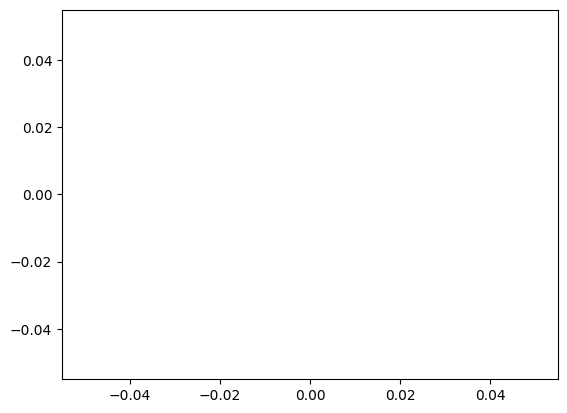

In [10]:
plt.plot()

NameError: name 'energies' is not defined